# Run predictions shifting distribution

Procedure
1. Clone 
```
!git clone https://github.com/dsikar/sdsandbox
```
2. Move
```
!mv  sdsandbox/src/* .

3. Delete bad image
```
!rm logs_Wed_Nov_25_23_39_22_2020/0_cam-image_array_.jpg
```

In [38]:
def GetJSONSteeringAngles(filemask):
    """
    Get steering angles stored as 'user/angle' attributes in .json files
    Inputs:
        filemask: string, path and mask
    Outputs
        svals: list, steering values
    """
    filemask = os.path.expanduser(filemask)
    path, mask = os.path.split(filemask)

    matches = []
    for root, dirnames, filenames in os.walk(path):
        for filename in fnmatch.filter(filenames, mask):
            matches.append(os.path.join(root, filename))
    # sort by create date
    # matches = sorted(matches, key=os.path.getmtime)
    # sort by filename prefix
    matches = sort_sdsandbox_files(matches)
    # steering values
    svals = []
    for fullpath in matches:
      # print(fullpath)
      frame_number = os.path.basename(fullpath).split("_")[0]
      json_filename = os.path.join(os.path.dirname(fullpath), "record_" + frame_number + ".json")
      jobj = load_json(json_filename)
      svals.append(jobj['user/angle'])
    return svals

def load_json(filepath):
    """
    Load a json file
    Inputs
        filepath: string, path to file
    Outputs
        data: dictionary, json key, value pairs
    Example
    path = "~/git/msc-data/unity/roboRacingLeague/log/logs_Sat_Nov_14_12_36_16_2020/record_11640.json"
    js = load_json(path)
    """
    with open(filepath, "rt") as fp:
        data = json.load(fp)
    return data 

def sort_sdsandbox_files(matches):
  """
  Sort sdsandbox files in format e.g. 'logs_Wed_Nov_25_23_39_22_2020/1339_cam-image_array_.jpg'
  This is to emulate a sort-by-date feature, once files have been copied and datetime stamp is lost

  Parameters
  -------
  matches: list of strings, image filepaths

  Output
  -------
  sorted_matches: list of strings, sorted list

  Example
  -------
  matches = sort_sdsandbox_files(matches)
  for match in matches:
    print(match)
  """
  filenums = {}
  sorted_matches = []
  for match in matches:
    # match ~ 'logs_Wed_Nov_25_23_39_22_2020/1339_cam-image_array_.jpg'
    # match.split('/')[-1].split('_')[0] ~ 1339
    filenums[int(match.split('/')[-1].split('_')[0])] = match

  filenums = sorted(filenums.items(), key=lambda filenums: filenums[0])
  for key in filenums:
    sorted_matches.append(key[1]) 

  return sorted_matches        

def GetPredictions(filemask, modelpath, datashift, modelname = 'nvidia2'):
    """
    Get predictions of a given model
    
    Parameters
    -------
        filemask: string, path of the images to generate steering angle predictions
        modelpath: string, path of the trained model 
        datashift: integer, RGB intensity mean shift to left (negative) or right (positive) or 
        input image RGB intensity mean
        modelname: string, model name refering to input geometry to use
    
    Output
    -------
        predictions: numpy array of floats, steering angle predictons
        
    Example:
    filemask = '../../../../Downloads/dataset/unity/genTrack/genTrackOneLap/logs_Wed_Nov_25_23_39_22_2020/*.jpg'
    modelpath = '../../../../Downloads/trained_models/nvidia2/20201207192948_nvidia2.h5'
    datashift = -10
    filename = 'nvidia2'
    
    p = GetPredictions(filemask, modelpath, datashift)
    
    """
    import os
    from tensorflow.python.keras.models import load_model
    import cv2
    import Augment_cls    

    model = load_model(modelpath)
    model.compile("sgd", "mse")
    
    filemask = os.path.expanduser(filemask)
    path, mask = os.path.split(filemask)

    matches = []
    for root, dirnames, filenames in os.walk(path):
        for filename in fnmatch.filter(filenames, mask):
            matches.append(os.path.join(root, filename))
    # sort by create date
    matches = sorted(matches, key=os.path.getmtime)
    # sort by filename prefix
    matches = sort_sdsandbox_files(matches)

    # steering values
    svals = []
    for fullpath in matches: 
      #image = cv2.imread(fullpath)
      image = Image.open(fullpath)
      #PIL Image as a numpy array
      image = np.array(image, dtype=np.float32)      
      # image = ag.resize_expected(image)
      image = ag.preprocess(image)
      image = image.reshape((1,) + image.shape)

      mod_pred = model.predict(image)   
      svals.append(mod_pred)
    return svals  

In [3]:
from tensorflow.python.keras.models import load_model
# import cv2


import matplotlib.image as mpimg
import matplotlib.pyplot as plt


import Augment_cls

modelpath = 'examples/20201207192948_nvidia2.h5'
modelname = 'nvidia2'
ag = Augment_cls.Augment_cls(modelname)
print("loading model", modelpath)
model = load_model(modelpath)
model.compile("sgd", "mse")

loading model examples/20201207192948_nvidia2.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/core.py:1030: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.0008796225301921368


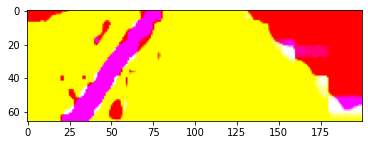

In [36]:
fullpath = 'logs_Wed_Nov_25_23_39_22_2020/10_cam-image_array_.jpg'
# image = mpimg.imread(fullpath) # cv2.imread(fullpath) # cv2 inverts R and B channels # 6.671416759490967
image = Image.open(fullpath)
#PIL Image as a numpy array
image = np.array(image, dtype=np.float32)
# image = cv2.imread(fullpath) # 6.4248524606227875 - does not seem to make much of a difference
# The image will be 1. resized to expected pre-processing size and 2.resized to expected
# size to be presented to network. This is network architecture and dataset dependant and
# currently managed in conf.py

# set to same image size expected from acquisition process
image = ag.resize_expected(image)
image = ag.preprocess(image)
plt.imshow(image)
image = image.reshape((1,) + image.shape)
mod_pred = model.predict(image)
print(mod_pred[0][0] * 25)

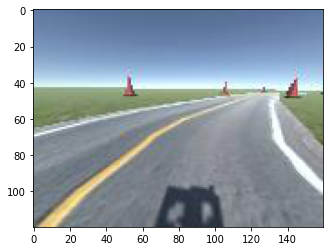

In [33]:
from PIL import Image
from io import BytesIO
import base64
# image = Image.open(BytesIO(base64.b64decode(fullpath))) # Incorrect padding
image = Image.open(fullpath)
plt.imshow(image)

In [6]:
print(tensorflow.__version__)

2.2.0


In [192]:
import tensorflow
print(tensorflow.__version__) # 2.8.0
# we need 2.2.0

2.8.0


# Installing Version of tensorflow used when training 20201207192948_nvidia2.h5

In [2]:
# %tensorflow_version 2.2.0
!pip install tensorflow==2.2.0
import tensorflow
print(tensorflow.__version__) # 2.2.0

2.2.0


In [166]:
mod_pred[0][0]

0.09744115

In [39]:
filemask = 'logs_Wed_Nov_25_23_39_22_2020/*.jpg'
modelpath = 'examples/20201207192948_nvidia2.h5'
datashift = -10

p = GetPredictions(filemask, modelpath, datashift)
# Error with path: logs_Wed_Nov_25_23_39_22_2020/0_cam-image_array_.jpg

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/core.py:1030: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [40]:

p

[array([[0.02602328, 0.05871429]], dtype=float32),
 array([[0.02676834, 0.06283262]], dtype=float32),
 array([[0.04162621, 0.09110095]], dtype=float32),
 array([[0.02070966, 0.08617469]], dtype=float32),
 array([[0.04186048, 0.08732412]], dtype=float32),
 array([[0.03716091, 0.07997031]], dtype=float32),
 array([[0.0388697 , 0.06492593]], dtype=float32),
 array([[0.03788997, 0.05994346]], dtype=float32),
 array([[0.03917978, 0.05924427]], dtype=float32),
 array([[0.03743223, 0.07380074]], dtype=float32),
 array([[0.00780969, 0.08512651]], dtype=float32),
 array([[0.00784971, 0.08477745]], dtype=float32),
 array([[0.00355986, 0.0828184 ]], dtype=float32),
 array([[0.00885224, 0.08016584]], dtype=float32),
 array([[0.05125994, 0.08141012]], dtype=float32),
 array([[0.04834332, 0.08572205]], dtype=float32),
 array([[0.05408766, 0.08401868]], dtype=float32),
 array([[0.0211665 , 0.08563509]], dtype=float32),
 array([[0.02172347, 0.07958811]], dtype=float32),
 array([[-0.00363015,  0.084428

In [23]:
# !git clone https://github.com/dsikar/sdsandbox
# !mv  sdsandbox/src/examples/20* examples 
# %cd sdsandbox
# !git pull
#%cd ..
# !ls
# !mv sdsandbox/src/examples/log* .
# !tar xvf logs_Wed_Nov_25_23_39_22_2020.tar.gz
# !ls logs_Wed_Nov_25_23_39_22_2020/
import json
import numpy as np
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
import os
import fnmatch

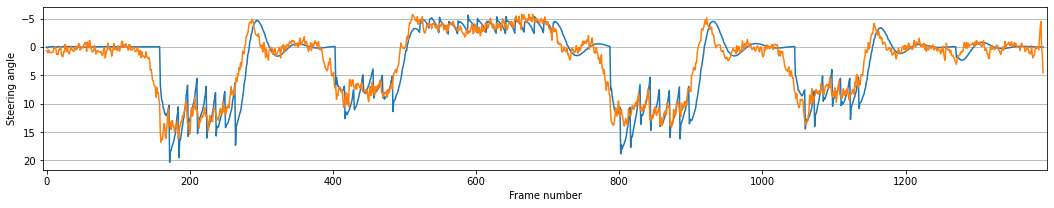

In [45]:
import os
import fnmatch
import json
import numpy as np
import matplotlib.pyplot as plt
# plot ground truth steering angles for
filemask = 'logs_Wed_Nov_25_23_39_22_2020/*.jpg'
g = GetJSONSteeringAngles(filemask)
# g = preds # 'str' object is not callable
# get predictions:
p = preds
p = np.asarray(p)
#  = GetPredictions(filemask, datashift)
# print(type(g)) # list
g = np.asarray(g)
# print(type(g)) # <class 'numpy.ndarray'>
plt.rcParams["figure.figsize"] = (18,3)
nc = 25 # norm. constant, maximum steering angle

plt.plot(g*nc)
plt.plot(p*nc)
# plt.plot(sarr[:,1]*25, label="simulator")

plt.ylabel('Steering angle')
plt.xlabel('Frame number')    
# Set a title of the current axes.
mytitle = 'Ground truth steering for logs_Wed_Nov_25_23_39_22_2020 - One lap recorded from Generated Track in "Auto Drive w Rec" mode'
#plt.title(mytitle)
plt.grid(axis='y')
# set limit
plt.xlim([-5,len(g)+5])
plt.gca().invert_yaxis()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


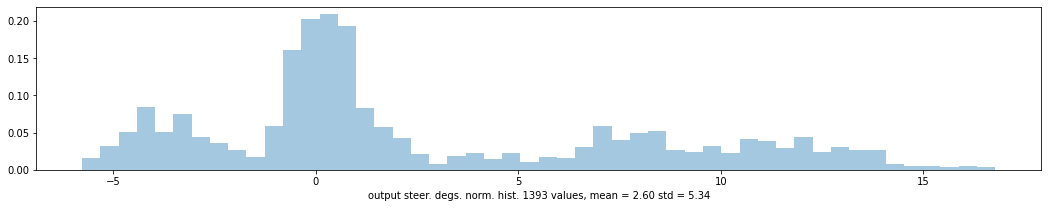

In [46]:
def listSteeringBins(svals, pname="output", save=True, nc=25, rmout=0):
    """
    Plot a steering values' histogram
    Inputs
        svals: list, array of normalized steering values
        pname: string, output plot name
        save: boolean, save plot to disk
        nc: int, normalization constant, used in the simulator to put angles in range
        -1, 1. Default is 25.
        rmout: integer, outlier range to remove
    Outputs
        none
    """
    svalscp = [element * nc for element in svals]
    values = len(svals)
    
    # remove outliers
    if(rmout>0):
        #my_iterator = filter(lambda svalscp: svalscp <= rmout and svalscp >= (-1 * rmout), svalscp)
        #svalsrmout = list(my_iterator)
        #svalscp = svalsrmout
        #values = len(svalsrmout)
        #print("Removed {} records".format(len(svals) - len(svalsrmout)))
        #svals = svalsrmout
        svals = removeOutliers(svalscp, rmout, nc)
        values = len(svals)
    mean = ("%.2f" % statistics.mean(svalscp))
    std = ("%.2f" % statistics.stdev(svalscp))
    plt.title=(pname)
    # NB Plotted as normalized histogram
    sns.distplot(svalscp, bins=nc*2, kde=False, norm_hist=True, 
    axlabel= pname + ' steer. degs. norm. hist. ' + str(values) + ' values, mean = ' + mean + ' std = ' + std)
    #if(save):
    #    sns.save("output.png")
    if(save):
        plt.savefig(pname + '.png')
    plt.show()

listSteeringBins(preds)

In [44]:
g.shape # (1394,)
p[0] # array([[0.10689256, 0.26171982]], dtype=float32)
p[0][0] # array([0.10689256, 0.26171982], dtype=float32)
p[0][0][0] # 0.106892556
p[0][0][1] # 0.26171982 
p[1] # array([[0.10308309, 0.262734  ]], dtype=float32)
p[1][0] # array([0.10308309, 0.262734  ], dtype=float32)
# p[1][1] # index 1 is out of bounds for axis 0 with size 1
p[1][0][0] # 0.10308309 # assumed steering angle
p[1][0][1] # 0.262734 # assumed acceleration
len(p) # 1393
preds = []
for i in range(0, len(p)):
  preds.append(p[i][0][0])


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


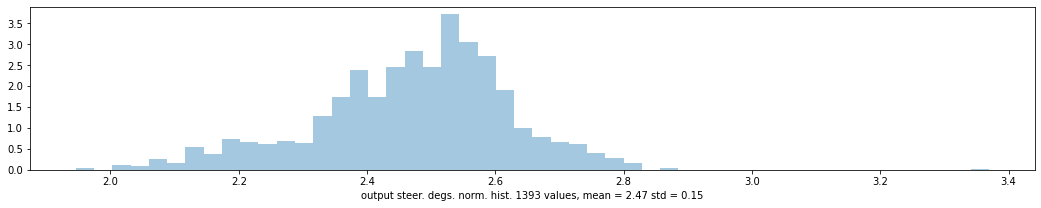

In [150]:
listSteeringBins(preds)

# Positive steering angle example, labelled dataset

In [156]:
# 1105_cam-image_array_.jpg
#!ls logs_Wed_Nov_25_23_39_22_2020/1105_cam-image_array_.jpg
# !ls logs_Wed_Nov_25_23_39_22_2020/*1105*
!cat logs_Wed_Nov_25_23_39_22_2020/record_1105.json
# {"cam/image_array":"1105_cam-image_array_.jpg","user/throttle":0.0,"user/angle":0.31525176763534548,"user/mode":"user","track/lap":0,"track/loc":21}
# 0.31525176763534548 * 25 = 7.88129419088 ~ 7.9 degrees

{"cam/image_array":"1105_cam-image_array_.jpg","user/throttle":0.0,"user/angle":0.31525176763534548,"user/mode":"user","track/lap":0,"track/loc":21}

# Corresponding prediction

In [ ]:
filemask = os.path.expanduser(filemask)
path, mask = os.path.split(filemask)

matches = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, mask):
        matches.append(os.path.join(root, filename))
# sort by create date
matches = sorted(matches, key=os.path.getmtime)

filenums = {}
for match in matches:
  # match ~ 'logs_Wed_Nov_25_23_39_22_2020/1339_cam-image_array_.jpg'
  # match.split('/')[-1].split('_')[0] ~ 1339
  filenums[int(match.split('/')[-1].split('_')[0])] = match

filenums = sorted(filenums.items(), key=lambda filenums: filenums[0])
for key in filenums:
  print(key[1])

In [ ]:
matches2 = sort_sdsandbox_files(matches)
for match in matches2:
  print(match)

logs_Wed_Nov_25_23_39_22_2020/0_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/1_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/2_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/3_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/4_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/5_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/6_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/7_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/8_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/9_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/10_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/11_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/12_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/13_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/14_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/15_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/16_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/17_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/18_cam-i

In [ ]:
strfile = 'logs_Wed_Nov_25_23_39_22_2020/1339_cam-image_array_.jpg'
strarr = strfile.split('/')
print(strfile.split('/')[-1].split('_')[0])

1339


In [ ]:
# remove bad image
!rm logs_Wed_Nov_25_23_39_22_2020/0_cam-image_array_.jpg